### Architecture 
In this experiment, early fusion is applied by using the EfficientNetB1 backbone to extract image embeddings. A small MLP is used to embed the tabular features, and both embeddings are concatenated. A final MLP head is then applied, and the model is trained and fine‑tuned using this combination. Light augmentation is added to the images with simple horizontal flipping. In each fold, the model is trained on 4 folds and validated on the remaining fold. After all folds, out‑of‑fold predictions are stored, and RMSE is calculated on these OOF predictions to generalize the overall performance.

<br>
<br>

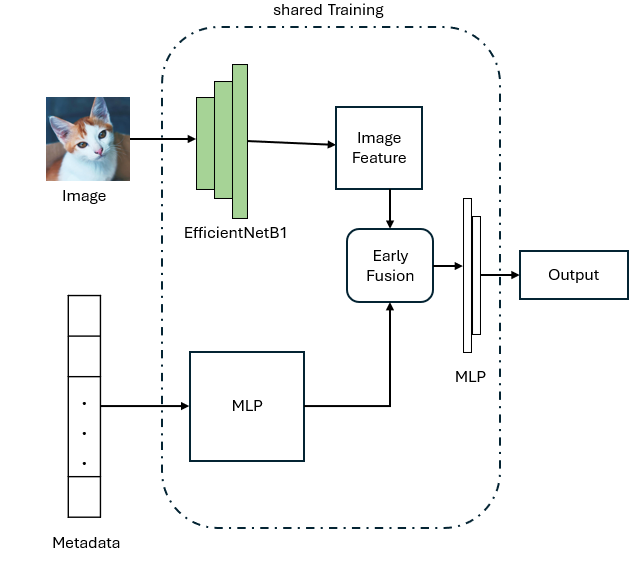

### Results Analysis
From the below, including metadata via early fusion (Exp4) slightly harms performance compared to the image‑only EfficientNet baseline (Exp2), as both the overall OOF RMSE and most bin‑wise RMSE values are higher for Exp4. In this configuration, the 12 binary metadata features appear not to provide complementary signal beyond what EfficientNet already learns from the images, so the added fusion layers mainly introduce extra parameters and noise rather than improving performance.Here in the table bins is the true values of pawpularity and results are splitted into bins to see where the each model is struggling, And the Exp2(Efficient without metadata) performs better
<br>
<br>
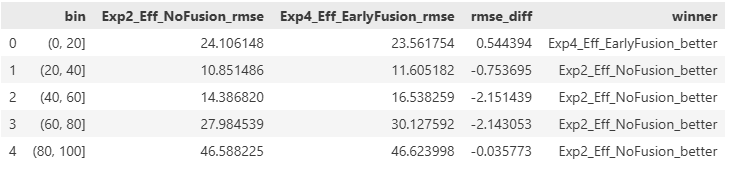

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [2]:
# Cell 1: imports & setup
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

gc.enable()

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

from src.config import EXP_CONFIGS
from src.utils import set_seed, save_config
from src.data import build_transforms, ImageTabDataset
from src.models import EarlyFusionNet



main_folder = ".."
data_csv = os.path.join(main_folder, "data", "train.csv")
img_folder = os.path.join(main_folder, "data", "train")
out_dir = os.path.join(main_folder, "outputs", "exp4")

df = pd.read_csv(data_csv)
cfg = EXP_CONFIGS["exp4"]   # define in config
TARGET = "Pawpularity"
tab_cols = [c for c in df.columns if c not in ["Id", TARGET]]

os.makedirs(out_dir, exist_ok=True)
save_config(cfg, out_dir)
set_seed(cfg["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/ghias/miniconda3/envs/rapids-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from src.train import run_single_fold

kf = KFold(n_splits=cfg["n_splits"], shuffle=True, random_state=cfg["seed"])
oof_pred = np.zeros(len(df))
oof_true = df[TARGET].values
fold_index = np.full(len(df), -1, dtype=int)
fold_rmse = []

start_all = time.time()
for fold, (tr_idx, val_idx) in enumerate(kf.split(df), start=1):
    print(f"\n=== {cfg['name']}: Fold {fold} ===")
    train_df = df.iloc[tr_idx].reset_index(drop=True)
    val_df   = df.iloc[val_idx].reset_index(drop=True)

    best_rmse, val_preds, val_targets, val_ids = run_single_fold(
    fold=fold,
    train_df=train_df,
    val_df=val_df,
    img_folder=img_folder,
    cfg=cfg,
    out_dir=out_dir,
    device=device,
    mode="fusion",      
    tab_cols=tab_cols,
    workers=16,
    pin_memory=True,
    persistent_workers=True,
    )

    oof_pred[val_idx] = val_preds
    fold_index[val_idx] = fold
    fold_rmse.append(best_rmse)
    print(f"Fold {fold} best RMSE: {best_rmse:.4f}")

all_sec = time.time() - start_all
print(f"\nTotal training time: {int(all_sec//60)}m {int(all_sec%60)}s")
# final metrics + OOF with fold column
oof_rmse = root_mean_squared_error(oof_true, oof_pred)
fold_rmse = np.array(fold_rmse)
print(f"\nOOF RMSE: {oof_rmse:.4f}")
print(f"Fold RMSEs: {fold_rmse.tolist()}  Mean={fold_rmse.mean():.4f}  Std={fold_rmse.std():.4f}")

oof_df = pd.DataFrame({
    "Id": df["Id"],
    "fold": fold_index,     
    "ytrue": oof_true,
    "oof_pred": oof_pred,
})
oof_df["abs_err"] = (oof_df["ytrue"] - oof_df["oof_pred"]).abs()
oof_df.to_csv(os.path.join(out_dir, "oof_detail.csv"), index=False)
oof_df.sort_values("abs_err", ascending=False).head(50).to_csv(
    os.path.join(out_dir, "top50_errors.csv"), index=False
)

np.save(os.path.join(out_dir, "oof_pred.npy"), oof_pred)
np.save(os.path.join(out_dir, "fold_rmse.npy"), fold_rmse)
with open(os.path.join(out_dir, "metrics.txt"), "w") as f:
    f.write(f"OOF_RMSE: {oof_rmse:.4f}\n")
    f.write(f"Fold_RMSE: {fold_rmse.tolist()}\nMean: {fold_rmse.mean():.4f}\nStd: {fold_rmse.std():.4f}\n")



=== Exp4_EffB1_TabMLP_Early_MLPHead: Fold 1 ===
Epoch 1/10 | Fold 1 | Train[MSE]: RMSE=39.4227 | ValRMSE: 33.6456
Epoch 2/10 | Fold 1 | Train[MSE]: RMSE=28.2088 | ValRMSE: 24.7174
Epoch 3/10 | Fold 1 | Train[MSE]: RMSE=19.4980 | ValRMSE: 20.7028
Epoch 4/10 | Fold 1 | Train[MSE]: RMSE=14.0654 | ValRMSE: 20.3216
Epoch 5/10 | Fold 1 | Train[MSE]: RMSE=11.4182 | ValRMSE: 20.4639
Epoch 6/10 | Fold 1 | Train[MSE]: RMSE=9.7364 | ValRMSE: 20.2776
Epoch 7/10 | Fold 1 | Train[MSE]: RMSE=8.7532 | ValRMSE: 20.6332
Epoch 8/10 | Fold 1 | Train[MSE]: RMSE=8.1376 | ValRMSE: 20.6197
Epoch 9/10 | Fold 1 | Train[MSE]: RMSE=7.7912 | ValRMSE: 20.5335
Epoch 10/10 | Fold 1 | Train[MSE]: RMSE=7.3400 | ValRMSE: 20.5459
Fold 1 best RMSE: 20.2776

=== Exp4_EffB1_TabMLP_Early_MLPHead: Fold 2 ===
Epoch 1/10 | Fold 2 | Train[MSE]: RMSE=38.9546 | ValRMSE: 32.7290
Epoch 2/10 | Fold 2 | Train[MSE]: RMSE=27.2044 | ValRMSE: 25.1159
Epoch 3/10 | Fold 2 | Train[MSE]: RMSE=18.6677 | ValRMSE: 19.7299
Epoch 4/10 | Fold 2 | 

In [3]:
import pandas
df = pd.read_csv(out_dir+"/oof_detail.csv")
fold_rmse = []

for fold in range(1, 6):
    sub = df[df.fold == fold]
    rmse = ((sub.ytrue - sub.oof_pred)**2).mean() ** 0.5
    fold_rmse.append(rmse)
    print(f"Fold {fold} OOF RMSE: {rmse:.4f} (n={len(sub)})")

Fold 1 OOF RMSE: 20.2776 (n=1983)
Fold 2 OOF RMSE: 19.7299 (n=1983)
Fold 3 OOF RMSE: 19.3609 (n=1982)
Fold 4 OOF RMSE: 19.9931 (n=1982)
Fold 5 OOF RMSE: 20.1416 (n=1982)


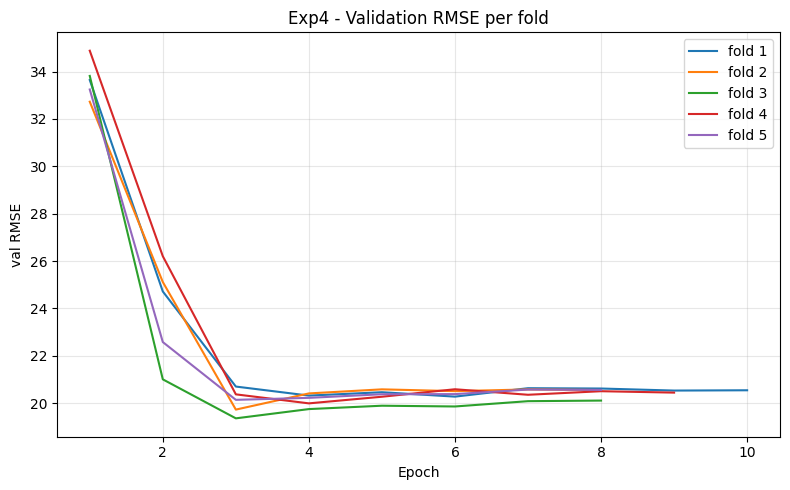

In [4]:
from src.plot import plot_all_folds_history
plot_all_folds_history(out_dir, folds=[1,2,3,4,5], title_prefix="Exp4")

In [5]:
#  Inspect worst error rows

errors_path = os.path.join(out_dir, "top50_errors.csv")
err_df = pd.read_csv(errors_path)
err_df.head()

Id  fold  ytrue   oof_pred    abs_err
0  4ab407534f6153ba427f901eb2b45c5b     5    100  14.309258  85.690742
1  118ca1a5339f8d6f2794dfc7086ec46a     4     94   9.120928  84.879072
2  00768659c1c90409f81dcdecbd270513     1    100  18.864895  81.135105
3  bc39a9c4ae544bfc4118d59b9b089135     3      5  85.897041  80.897041
4  d26a260dddd3a5001f47bb9209e85b12     1     92  11.868005  80.131995

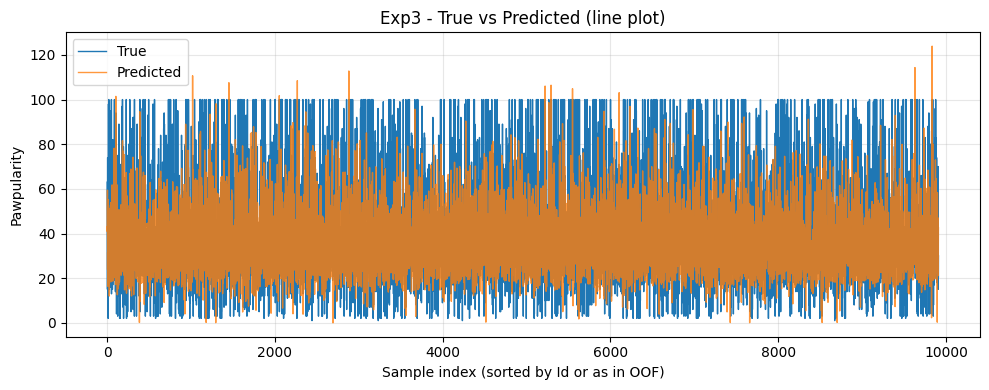

In [6]:
import os
import pandas as pd
from src.plot import (
   plot_oof_true_pred_lines,
    show_images_grid,
)

# Load OOF detail and top-errors
oof_df = pd.read_csv(os.path.join(out_dir, "oof_detail.csv"))
err_df = pd.read_csv(os.path.join(out_dir, "top50_errors.csv"))

# Plots
plot_oof_true_pred_lines(oof_df, title_prefix="Exp3")





Exp2_Eff_NoFusion OOF RMSE: 19.177387932516293
Exp4_Eff_EarlyFusion OOF RMSE: 19.90331621767278
ΔRMSE (Exp2_Eff_NoFusion - Exp4_Eff_EarlyFusion): -0.7259282851564883


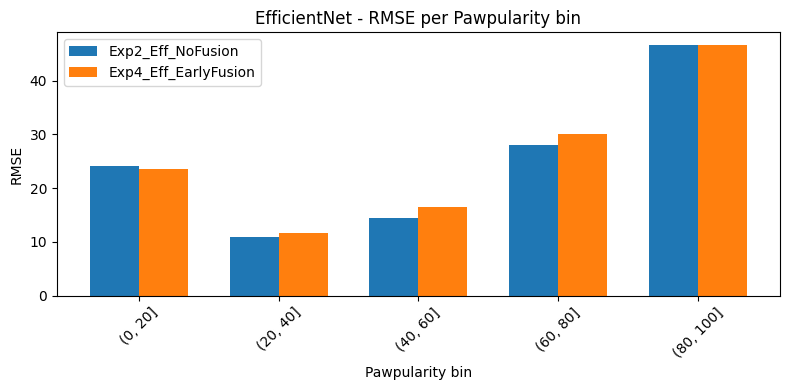

In [5]:
from src.plot import compare_oof_by_bins
bins = [0, 20, 40, 60, 80, 100]

df_bins, rmse3_all, rmse5_all, gap = compare_oof_by_bins(
    oof_path_a="../outputs/exp2/oof_detail.csv",
    oof_path_b="../outputs/exp4/oof_detail.csv",
    bins=bins,
    label_a="Exp2_Eff_NoFusion",
    label_b="Exp4_Eff_EarlyFusion",
    title_prefix="EfficientNet",
)

In [6]:
df_bins.head()

bin  Exp2_Eff_NoFusion_rmse  Exp4_Eff_EarlyFusion_rmse  rmse_diff  \
0    (0, 20]               24.106148                  23.561754   0.544394   
1   (20, 40]               10.851486                  11.605182  -0.753695   
2   (40, 60]               14.386820                  16.538259  -2.151439   
3   (60, 80]               27.984539                  30.127592  -2.143053   
4  (80, 100]               46.588225                  46.623998  -0.035773   

                        winner  
0  Exp4_Eff_EarlyFusion_better  
1     Exp2_Eff_NoFusion_better  
2     Exp2_Eff_NoFusion_better  
3     Exp2_Eff_NoFusion_better  
4     Exp2_Eff_NoFusion_better

> From the results above, we can see that the metadata inclusion as early fusion(Exp4) harm the performance of model which has better results without metadata inclusion. this is due to the reason that CNN can't capture the semantics pattern of images with metadata. 

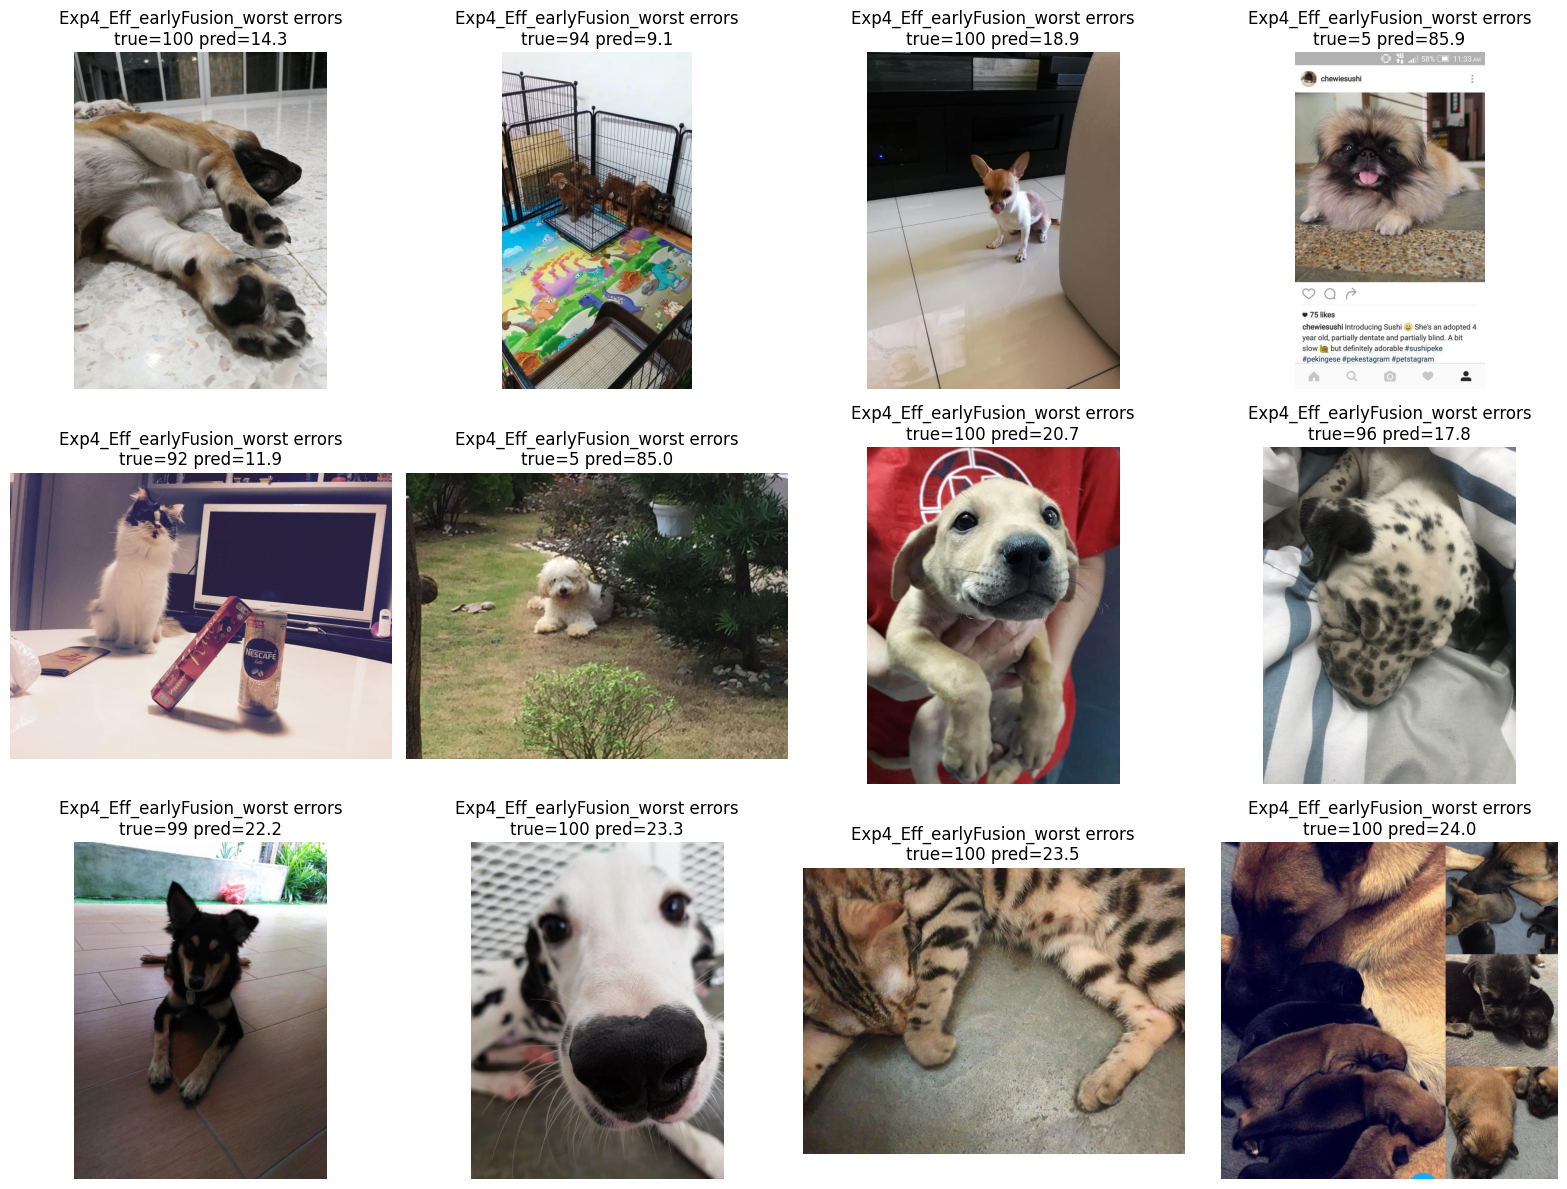

In [9]:
# Images of worst errors
img_folder = os.path.join(main_folder, "data", "train")
show_images_grid(err_df, img_folder, n=12, title_prefix="Exp4_Eff_earlyFusion_worst errors")

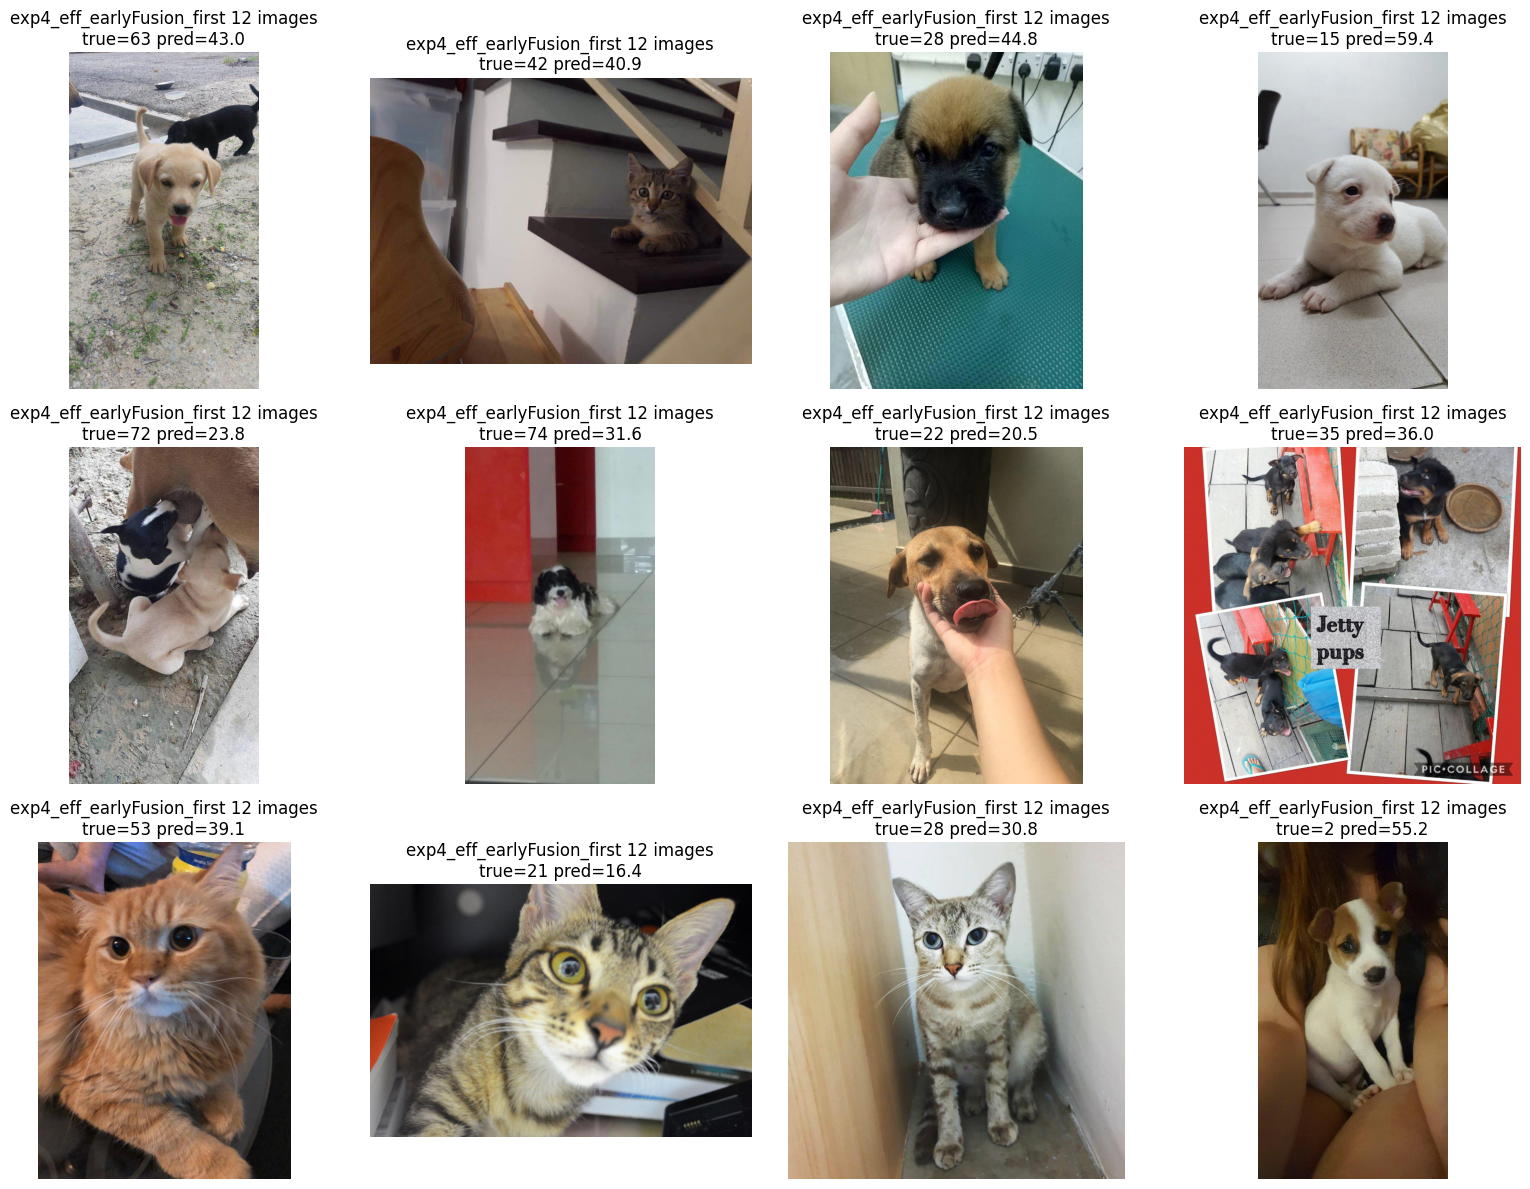

In [11]:

show_images_grid(oof_df, img_folder, n=12, title_prefix="exp4_eff_earlyFusion_first 12 images")